In [4]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from implementations import *
from utilitaries import *

Data loading
===

In [92]:
from proj1_helpers import *

labels, raw_features, indices = load_csv_data('train.csv', sub_sample=False)
# where b(background) -> -1 and s(signal) -> 1
n_samples, n_raw_features = np.shape(raw_features)
print(f'Dimension: {np.shape(raw_features)}')

Dimension: (250000, 30)


Data preprocessing
===

In [93]:
# A vector contaning the indices of features from raw_features kept for analysis:
feature_indices = []

In [94]:
# Converting meaningless -999 to NaN:
features = meaningless_to_nan(raw_features)

In [95]:
# NaN proportion: we believe that features with too many missing 
# values (NaN) are unlikely to carry much useful information (TO BE DISCUSSED):

from utilitaries import *
nan_prop = nan_proportion(features)
print(nan_prop)

[[ 0.        0.        0.        0.        4.        5.        6.
   0.        0.        0.        0.        0.       12.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.       23.       24.       25.       26.       27.
  28.        0.      ]
 [ 0.152456  0.        0.        0.        0.709828  0.709828  0.709828
   0.        0.        0.        0.        0.        0.709828  0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.399652  0.399652  0.399652  0.709828  0.709828
   0.709828  0.      ]]


In [96]:
# For example, we could say : features with p > 0.15 are to be discarded (TO BE DISCUSSED):

reduced_data = np.delete(features, np.s_[0,4,5,6,12,23,24,25,26,27,28], axis=1)
print(f'Dimension: {np.shape(reduced_data)}')

# 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
#   0 1 2       3 4 5 6  7     8  9  10 11 12 13 14 15 16 17                   18

Dimension: (250000, 19)


In [86]:
#We can also standardize the data (TO BE DISCUSSED):

std_data = standardize(reduced_data)
print(std_data)

[[ 0.06833197  0.40768027 -0.46996624 ...  0.38684673  1.04440205
   0.4125105 ]
 [ 0.55250482  0.54013641 -0.15316749 ... -0.35771893  0.02130497
  -0.27381996]
 [ 3.19515553  1.09655998 -0.34970965 ...  0.40013535  0.02130497
  -0.29396985]
 ...
 [ 0.31931645 -0.13086367 -0.28495489 ... -0.08608887  0.02130497
  -0.31701723]
 [-0.84532397 -0.30297338 -0.69737766 ... -0.76742886 -1.00179211
  -0.74543941]
 [ 0.66533608 -0.25352276 -0.79202769 ... -0.87267059 -1.00179211
  -0.74543941]]


Features exploration and selection
===

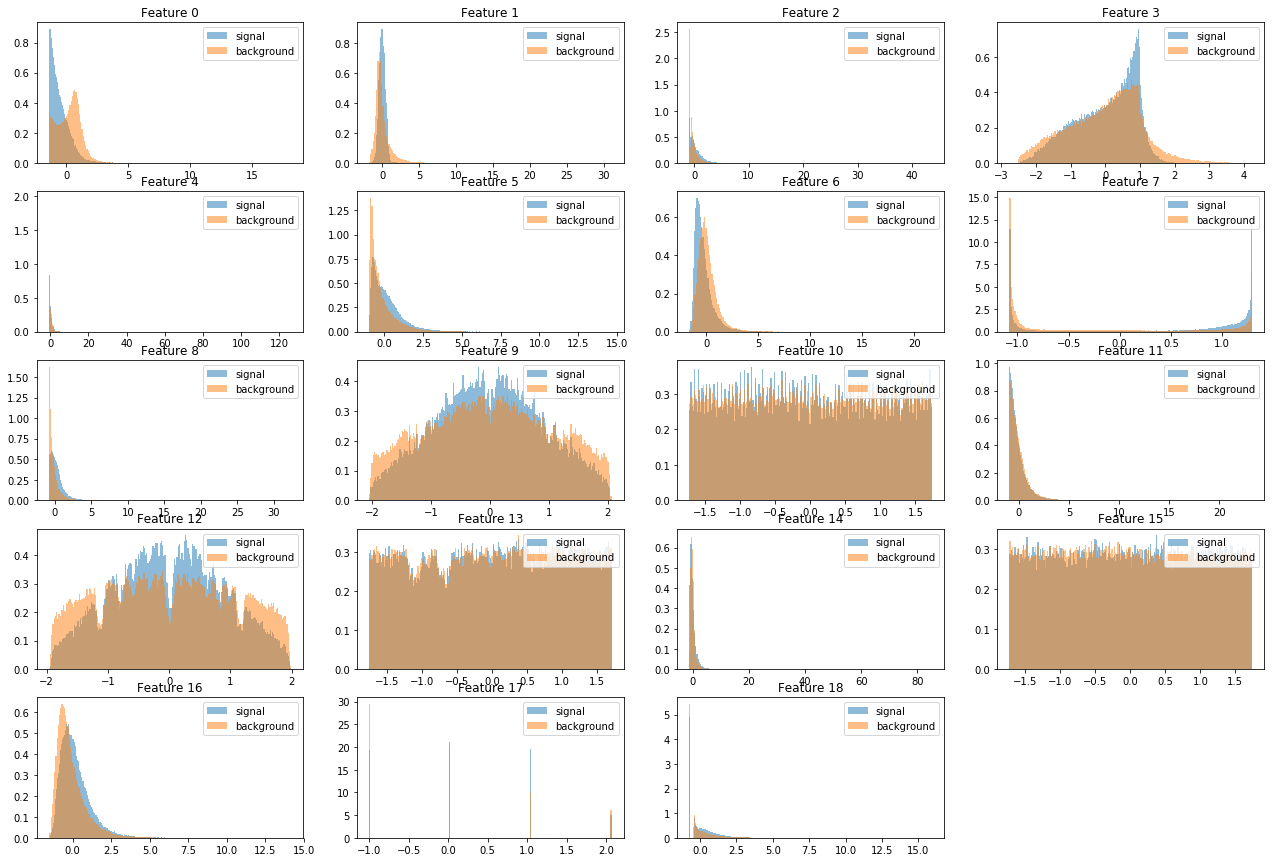

In [99]:
plt.figure(figsize=(20,15))

peaks = 200

s_data = std_data[labels == 1,:]
bg_data = std_data[labels == -1,:]
n_samples, n_features = np.shape(std_data)

for i in range(n_features):
    plt.subplot(5,4,i+1)
    plt.hist(s_data[:,i][~np.isnan(s_data[:,i])], peaks, density=1, alpha=0.5, label='signal')
    plt.hist(bg_data[:,i][~np.isnan(bg_data[:,i])], peaks, density=1, alpha=0.5, label='background')
    plt.legend(loc='upper right')
    plt.title(f'Feature {i}')

Feature reduction
===

feature=5 and feature=16 [[1.         0.90448146]
 [0.90448146 1.        ]]
feature=5 and feature=18 [[1.         0.96562839]
 [0.96562839 1.        ]]
feature=16 and feature=5 [[1.         0.90448146]
 [0.90448146 1.        ]]
feature=16 and feature=18 [[1.         0.88441286]
 [0.88441286 1.        ]]
feature=18 and feature=5 [[1.         0.96562839]
 [0.96562839 1.        ]]
feature=18 and feature=16 [[1.         0.88441286]
 [0.88441286 1.        ]]


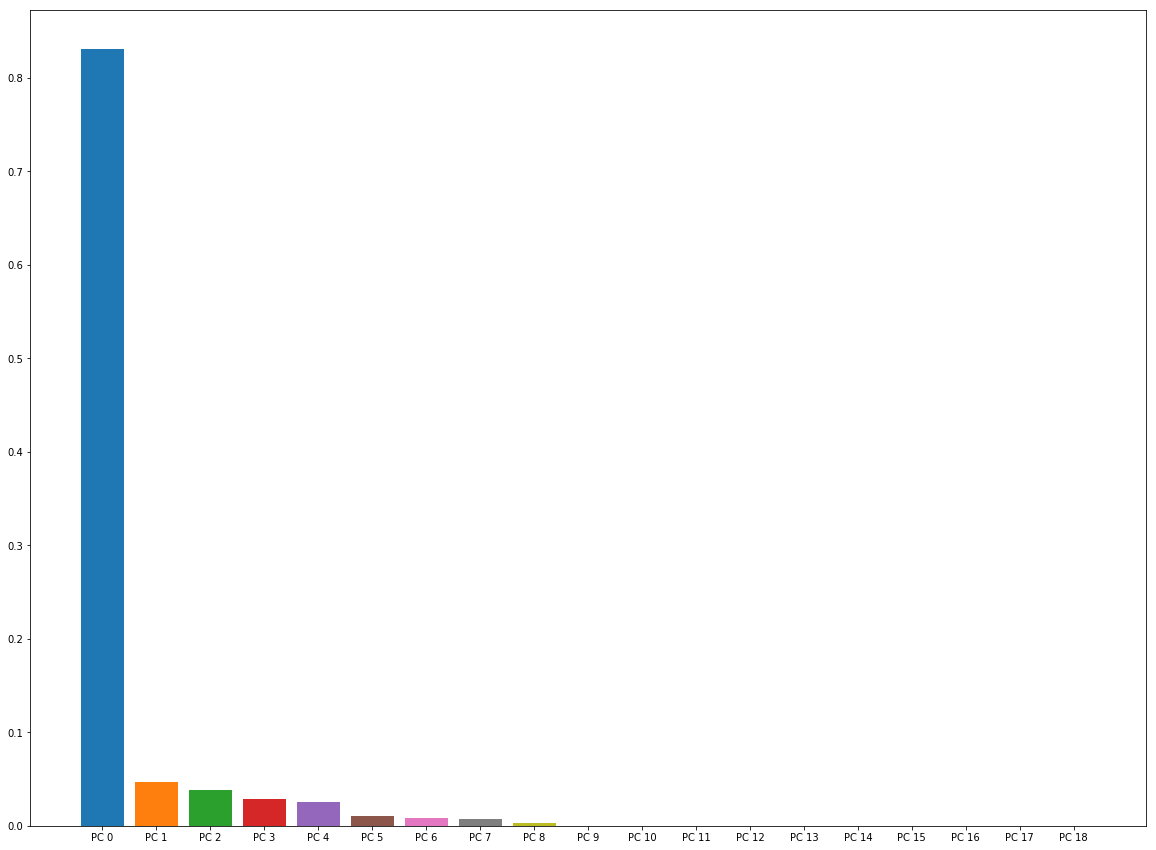

In [43]:
#ideas to reduce the features

#low variance filter : data columns with too little changes carry little info
variances = np.var(clean_data, axis = 0) / np.linalg.norm(clean_data, axis = 0)
print(variances)
# can we set a threshold?

#high correlation filter : data columns with similar trends carry similar info
correlation_pairs = np.ones((2,2))
for i in range(n_features):
    for j in range(n_features):
        correlation_pairs = np.corrcoef(std_data[:,i],std_data[:,j])
        #print("feature={f1} and feature={f2}".format(f1=i,f2=j), np.corrcoef(std_data[:,i],std_data[:,j]))
        if correlation_pairs[0,1] > 0.85 and i != j:
            print("feature={f1} and feature={f2}".format(f1=i,f2=j), np.corrcoef(std_data[:,i],std_data[:,j]))
# results: high correlated > 0.85
# features 5 and 16 + 5 and 18 + 16 and 18

#backward feature elimination: we remove one input feature at a time, train
# the same model on n-1...

#Principal component analysis:

all_mean = np.mean(np.transpose(clean_data),axis=1)
centered_data = clean_data - all_mean
cov_matrix = np.cov(np.transpose(centered_data))
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
total = sum(eigenvalues)
variances =[]
for i in range(n_features):
    eigenpairs =[(np.abs(eigenvalues[i]),eigenvectors[:,i])]
    eigenpairs.sort()
    eigenpairs.reverse()
for i in sorted(eigenvalues,reverse=True):
    variances.append((i/total))

plt.figure(figsize=(20,15))
for i in range(n_features):
    plt.bar('PC %s'%i,variances[i])

In [42]:
from additional_functions import *
def ridge_regression_demo(std_data,labels,degree,ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, -1, 10)
    # split data
    x_tr, x_te, y_tr, y_te = split_data(std_data,labels,ratio, seed)
    # form tx
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)
    # ridge regression with different lambda
    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
         # ridge regression
            weight_tr,loss_tr = ridge_regression(y_tr, tx_tr, lambda_)
            weight_te,loss_te = ridge_regression(y_te, tx_te, lambda_)
            rmse_tr.append(np.sqrt(2 * loss_tr))
            rmse_te.append(np.sqrt(2 * loss_te))

            #print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               #p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

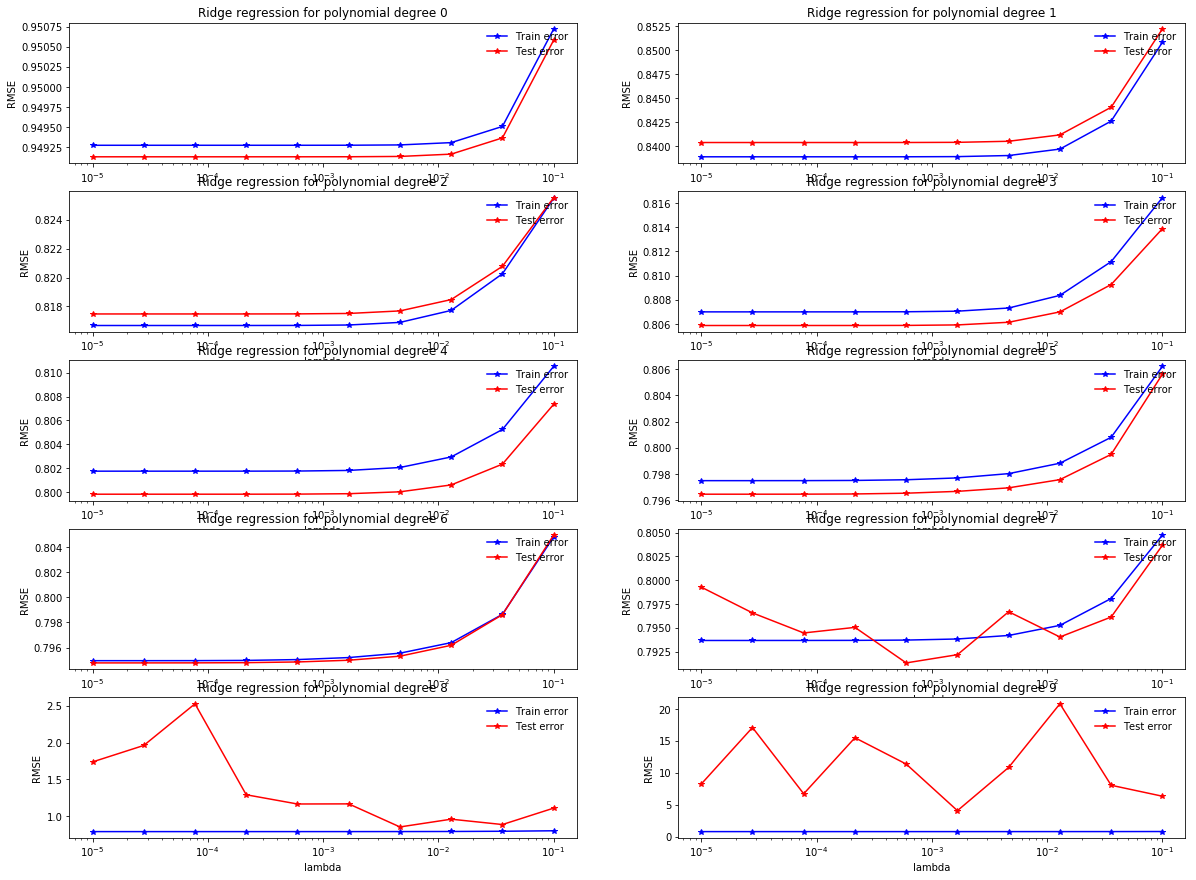

In [43]:
seed = 56
split_ratio = 0.5
plt.figure(figsize=(20,15))

for degree in range(10):
    plt.subplot(5,2,degree+1)
    ridge_regression_demo(std_data,labels, degree, split_ratio, seed)
